# Introduction to Qiskit 

The goal of this notebook is to convey a basic knowledge of Qiskit, a python package that can be used simulate quantum computing circuits.

## Install Qiskit

First, we install qiskit in a virtual environment to avoid any conflicts with other python packages.
(For details, see https://qiskit.org/documentation/getting_started.html).
This is not mandatory, but it is necessary that you obtain a working python + Qiskit setup.

## Florians comment on using venv

I do not recommend running the two commented lines, especially not from the notebook

Instead run the following in your favorite terminal:
```bash
/path/to/bin/python3.11 -m pip install virtualenv
/path/to/bin/python3.11 -m virtualenv ./qi
```
where `/path/to/...` should be the location where you installed python3.11.


Then instead of running `source ./qi/bin/activate`, set the binary in `./qi/bin/python` as your IDE's interpreter. `source ./qi/bin/activate` (or `activate.###` where ### is the name for your sh flavor, e.g. csh and fish) should only be necessary when working in the terminal (but most IDEs launch this automatically)

Note I recommend PyCharm as IDE, as it has all the features I stated above, plus it is free as a student.

In [1]:
%%capture
# !python3 -m venv ./qi
# !source ./qi/bin/activate
!pip install 'qiskit[visualization]' qiskit_aer numpy matplotlib

## Import packages

In [2]:
import qiskit as qi
import qiskit_aer as qi_aer
import numpy as np
from matplotlib import pyplot as plt

## Custom Functions
These functions are utility functions to simplify coding

In [3]:
def get_simulator() -> qi_aer.AerProvider:
    try:
        return qi_aer.Aer.get_backend('statevector_simulator')
    except:
        return qi_aer.BasicAer.get_backend('statevector_simulator')

def simulate_and_plot(qc: qi.QuantumCircuit, n: int = 1024, title: str = 'Measurement Distribution') -> None:
    simulator_run = simulator.run(qc, shots = n)
    
    # Get the results
    result = simulator_run.result()
    del simulator_run
    
    counts = result.get_counts()
    x = counts.keys()
    y = counts.values()
    
    plt.bar(x,y)
    
    plt.xlabel('Result')
    plt.ylabel('Counts')
    plt.title(title)
    
    plt.show()

## Construction of an exemplary quantum circuit

Here, we build a basic circuit that constructs the Bell State
$
\begin{align}
| \phi \rangle = \frac{1}{\sqrt{2}} \left( | 00 \rangle + | 11 \rangle \right)
\end{align}
$

Given two qubits in the state $| 0 \rangle$, i.e. the system is in a product state $| 0 \rangle \otimes | 0 \rangle \equiv | 0 \rangle ^{\otimes 2} \equiv | 0 0 \rangle$, the given Bell pair can be prepared by

first applying a *Hadamard* to the first qubit, creating the superposition $ | 0 \rangle \otimes | 0 \rangle  \to \frac{1}{\sqrt{2}} \left( | 0 \rangle + | 1 \rangle \right) \otimes | 0 \rangle$.

Then we apply a *CNOT* from the first to the second qubit $ \frac{1}{\sqrt{2}} \left( | 0 \rangle + | 1 \rangle \right) \otimes | 0 \rangle \to  \frac{1}{\sqrt{2}} \left( | 0 \rangle  \otimes | 0 \rangle + | 1 \rangle  \otimes | 1 \rangle \right)$.

Now we implement this in Qiskit.

### Constructing circuits in Qiskit

In Qiskit, a quantum circuit is composed of different *registers*.
One differentiates between two kinds of registers: (i) a quantum register where your qubits live and where quantum gates and measurements can be executed and (ii) a quantum register where the outcome of a measurement can be stored.

In the next lines, the initialisation of a $N$ qubit register and a $M$ bit classical register is shown as well as the initialisation of a quantum circuit.

In [4]:
N=2 #Number of qubits
M=2 #Number of classical bits 
qr = qi.QuantumRegister(N,"Data")
cr = qi.ClassicalRegister(M,"Measurement Results")

qc = qi.QuantumCircuit(qr,cr) 
#qc is now the quantum circuit to which we
#can add gates and measurements in the follow

We can visualise our quantum circuit at any instance of its implementation via the following function.

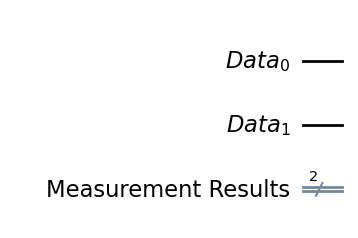

In [5]:
qc.draw(output= 'mpl')

We proceed by applying a Hadamard gate on our first qubit, followed by a C$_1$NOT$_2$ gate. We draw the circuit afterwards.

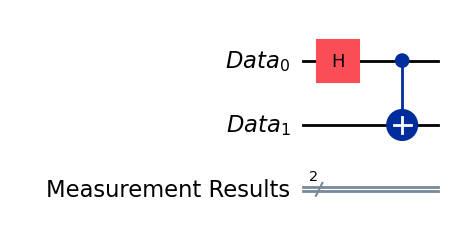

In [6]:
qc.h(qr[0])
qc.cx(qr[0],qr[1])
qc.draw(output= 'mpl')

As you see, to append new gates you can use the syntax *qc.gate(qubit_address)*. In the example above we used the previously define quantum register to adress our qubits. Note that for multi qubit gates, the number of provided qubit addresses must match the number of qubits involved in the gate. For the CNOT gate, the conventinon in Qiskit is to specify the control qubit first.

To finalize our circuit, we now measure both qubits in the computational basis.

Note that with .measure(qubit_address, classical_bit_address) you always measure in the computational basis.

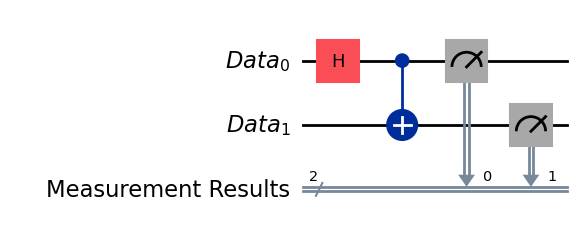

In [7]:
qc.measure(qr,cr)

qc.draw(output= 'mpl')

What is left to do, is to *run* this circuit and to verify it by taking the measurement statistics of measuring in the comutational basis.

Note that we only verfy if really prepared a maximally entangled state $\frac{1}{\sqrt{2}} \left( | 00 \rangle \pm | 11 \rangle \right)$ . The relative phase $\pm$ will not be accessible in this measurement.

To run the circuit we will need to make use of a so-called *simulator* which in our case simulates the wavefunction of the initial $| 00 \rangle$ state evolving through the circuit.

In [8]:
try:
    simulator = qi_aer.Aer.get_backend('statevector_simulator')
except:
    simulator = qi_aer.BasicAer.get_backend('statevector_simulator')


simulator_run = simulator.run(qc,shots = 1)

# Get the results
result = simulator_run.result()
del simulator_run
# Get the post measurement state
output_state = result.get_statevector(qc)

# Get the measurement outcomes
measurement_results = result.get_counts()

# The raw results are a dictionary with measurement outcomes as keys and counts as values
print(measurement_results)
output_state.draw(output='latex')

# We extract this datat and print it in a nice way
m = list(measurement_results.keys())[0]
l = output_state.draw(output='latex_source').replace('\\rangle','>')
print('Measurement outcome: {}, Post-measurement state: {}'.format(m,l))

{'00': 1}
Measurement outcome: 00, Post-measurement state:  |00>


You can rerun the cell above to convince yourself that a probabilistic experiment is simulated.

## Task 1 (1)
Using the previous quantum circuit and code examples, simulate 1000 runs (shots) of this simulation and plot a histogram of the measurement outcomes.

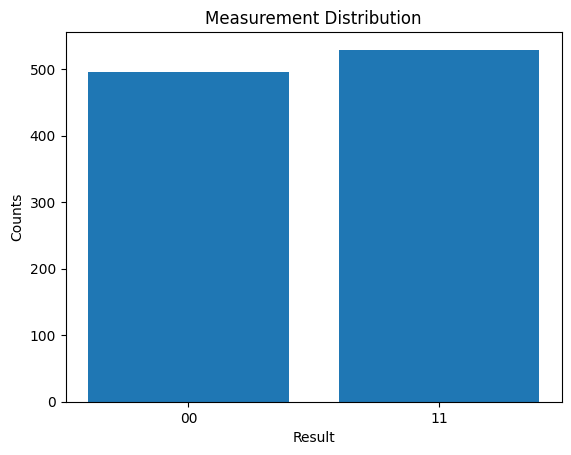

In [9]:
simulate_and_plot(qc)

## Deutsch algorithm
We will now go step by step to implement the Deutsch algorithm.


## Task 2 (1)
Create a two qubit quantum register and a single bit classical register and construct a quantum circuit.

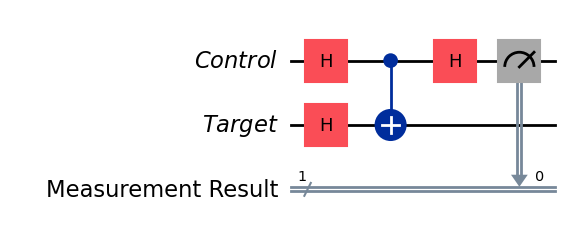

In [10]:
qr_i = qi.QuantumRegister(1,"Control")
qr_b = qi.QuantumRegister(1,"Target")
cr = qi.ClassicalRegister(1,"Measurement Result")

qc = qi.QuantumCircuit(qr_i,qr_b,cr) 

qc.h(qr_i)
qc.h(qr_b)
qc.cx(qr_i,qr_b)
qc.h(qr_i)

qc.measure(qr_i,cr)

qc.draw(output= 'mpl')

In [11]:
# simulate_and_plot(qc)

## Task 3 (1)
Implement the operation $U_I$ that you determined in subtask (a) of Problem 3. Draw the circuit.

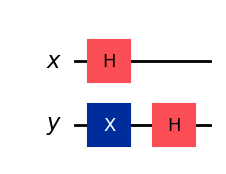

In [12]:
qr_x = qi.QuantumRegister(1,"x")
qr_y = qi.QuantumRegister(1,"y")

U_I = qi.QuantumCircuit(qr_x,qr_y) 

U_I.x(qr_y)
U_I.h(qr_x)
U_I.h(qr_y)

U_I.draw(output= 'mpl')

## Task 4 (1)
By using the Qiskit function .copy(), construct the two circuits corresponding to a balanced and an unbalanced function $f$ respectively.

In [13]:
%%capture
qr_x = qi.QuantumRegister(1,"x")
qr_y = qi.QuantumRegister(1,"y")

f = qi.QuantumCircuit(qr_x, qr_y)

# unbalanced
f_u = U_I.copy()
# f_u.compose(f, inplace=False, front=True)

# balanced
f_b = U_I # doesn't need to copy
f_u.compose(f, inplace=False, front=True)
f_b.cx(qr_x,qr_y)

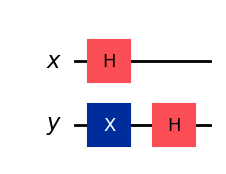

In [14]:
f_u.draw(output= 'mpl')

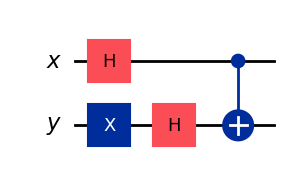

In [15]:
f_b.draw(output= 'mpl')

## Task 5 (2)
Measure now the first qubit for both ciruits after having applied another Hadamard gate on the first qubit and verify that the result corresponds to your expectations.

In [16]:
cr = qi.ClassicalRegister(1,"Measurement Results")

f_m = qi.QuantumCircuit(qr_x, qr_y,cr)
f_m.h(qr_x)
f_m.measure(qr_x,cr[0])
# qc_end.measure(qr_y,cr[0])
# qc_end.measure(qr_f,cr[0])

# unbalanced
f_u.compose(f_m, inplace=True, front=False)

# balanced
f_b.compose(f_m, inplace=True, front=False)

for title,f in [('Balanced',f_b), ('Unbalanced',f_u)]:
    simulator_run = simulator.run(f, shots = 1)
    
    # Get the results
    result = simulator_run.result()
    del simulator_run
    
    print(f'{title} f:', list(result.get_counts().keys())[0])

Balanced f: 1
Unbalanced f: 0


## Bernstein Vazirani problem
The goal of this part is to simulate a quantum circuit that solves the Bernstein-Vazirani problem.

Most of the code is provided, you only need to complete one step.

We start with the necessary variable initialisations.

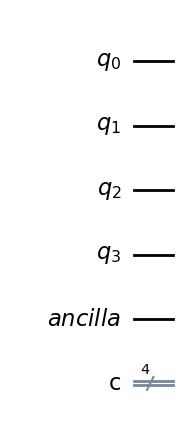

In [21]:
n = 4 #number of bits
shots = 10 #number of simulation runs

# Create a random bit string a of length n.
a = np.random.randint(0, 2, n)

# Create a quantum register of n qubits
quantum_register = qi.QuantumRegister(n, 'q')
# Create ancilla quantum register of 1 qubit
ancilla = qi.QuantumRegister(1, 'ancilla')
# Create classical register of n bits
classical_register = qi.ClassicalRegister(n, 'c')

# Initialize a quantum circuit containing the previously
# created registers.
qc = qi.QuantumCircuit(quantum_register, ancilla, classical_register)
qc.draw(output= 'mpl')

## Task 6 (2)
As you know, all qubits are now in the 0 state.
Add the appropriate gates to obtain the correct initial state to solve the Bernstein-Vazirani problem, follow your results in Problem 5.

In [22]:
%%capture
for i in range(n):
    qc.h(i)

qc.x(ancilla)
qc.h(ancilla)

Now the remaining implementation of the algorithm is shown for you.

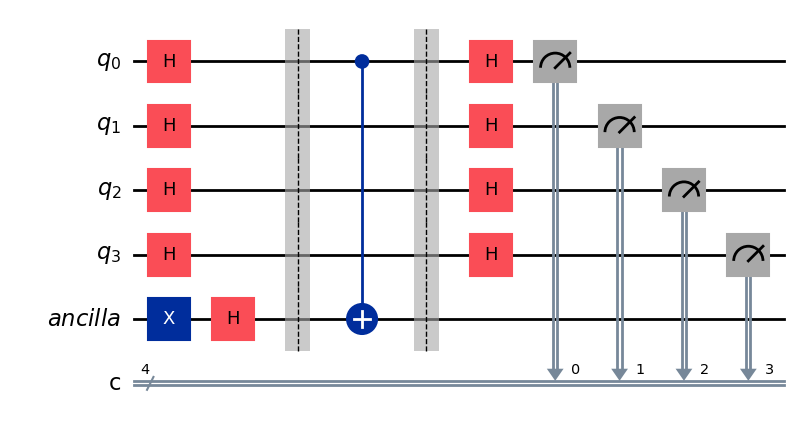

In [23]:
qc.barrier()

### APPLY QUANTUM BLACK BOX ###

# Implement the oracle (function f) using CNOT gates.
for control_qubit, cbit in zip(quantum_register, a):
    if cbit == 1:
        # Add a CNOT with control_qubit controlling a Pauli X
        # acting on ancilla.
        qc.cx(control_qubit, ancilla)

# Mark this position of the circuit with a barrier.
qc.barrier()

# Apply a Hadamard gate on each of the qubits in quantum_register.
qc.h(quantum_register)


### MEASUREMENT ###

# Measure the qubits in quantum_register and save the values to
# classical_register.
qc.measure(quantum_register, classical_register)
qc.draw(output= 'mpl')


What is left to do is running the circuit and checking the outcome.

In [24]:
### SIMULATION ###

# Create and run a simulation job for this circuit.
simulator_run = simulator.run(qc, shots = n)

# Get the results
result = simulator_run.result()
del simulator_run

# Get the outputs of the simulation.
# counts is a dictionary mapping the classical outputs to the number
# how often this output occurred. The classical output is given as a
# bit string with bits ordered from bit n to 0.
counts = result.get_counts()


### SHOW RESULTS ###

# Show the output of the simulation.
for output, count in counts.items():
    print("Measured result  %s  in%4d/%d  simulation runs."
          %(output[::-1], count, shots))
# Show the input bit string  a  for comparison.
print("Check:       a = %s."%(''.join(str(i) for i in a)))

Measured result  1000  in   4/10  simulation runs.
Check:       a = 1000.
